In [1]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test   
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines import NelsonAalenFitter
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from lifelines import CoxPHFitter
import pandas as pd
import numpy as np
import datetime
from functools import reduce
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as st

In [2]:
def data_preprocess(df, start_date, cut_off_date, last_date):
    '''
    inputs:
    dataset to be processed
    start_date: the start date of the 'LastWorkingDate' 
    cut_off_date: the end date of the training dataset 
    last_date: end date of validation/test dataset
    
    output:
    data: a merge of several dataframes engineered from raw dataset
    1. df_demograph: dataframe of unique values for demographic data
    2. df_salary_change: dataframe engineered from 'Salary'to derive the 'increment' column
    3. df_promotion: dataframe engineered from 'Joining Designation' and 'Designation' to derive 'Promotion'
    4. df_total: dataframe engineered to derive the total business-value of the employee
    5. df_average: dataframe engineered to derive the total business-value of the employee
    6. df_working_days: dataframe engineered from the final and joining date
    7. df_reporting: dataframe engineered for the column indicating total reporting for each employee                                                                   
    8. df_target: dataframe created for the target variable with presence of last working date, labeled as 1.                                                              
    
    '''    
    # Demographic dataset creation for each employee
    df_demograph = df[['Emp_ID', 
                   'Age', 
                   "Gender", 
                   "City", 
                   "Education_Level"]].groupby('Emp_ID').max().reset_index()
    
    # Feature Engineer - min_salary, max_salary and increment
    df_salary_min = df.groupby('Emp_ID').min()['Salary'].reset_index()
    df_salary_min.columns =['Emp_ID', 
                            'Salary_min']
    df_salary_max = df.groupby('Emp_ID').max()['Salary'].reset_index()
    df_salary_max.columns =['Emp_ID', 
                            'Salary_max']    
    df_salary_change = pd.merge(df_salary_min, 
                                df_salary_max, 
                                how = 'inner', 
                                on = 'Emp_ID')
    df_salary_change['Increment'] = ((df_salary_change['Salary_max'] - df_salary_change['Salary_min'])/df_salary_change['Salary_min'] *100).astype(int)
    
    # Feature Engineering - Promotion if there is any increase in the designation. The more the number, higher the promotion
    df_promotion = df
    df_promotion["promotion"] = np.where(df_promotion['Joining Designation']==df_promotion['Designation'], 0, 
                                     df_promotion['Designation'] - df_promotion['Joining Designation'])
    df_promotion = df_promotion[['Emp_ID',
                                 'Joining Designation', 
                                 'Designation', 
                                 'promotion']].groupby("Emp_ID").max().reset_index()
    
    # Feature Engineering - total business value generated by the employee throughout his tenure or the cutoff date
    df_total = df.groupby('Emp_ID').sum()
    df_total = df_total["Total Business Value"].reset_index()
    df_total = df_total.set_axis(['Emp_ID', 
                                  'total_business_value'], 
                                 axis=1, 
                                 inplace=False)
    
    # Feature Engineering - average business value, average salary and average quarterly rating generated by the 
    #employee throughout his tenure or the cutoff date
    
    df_average = df.groupby('Emp_ID').mean()
    df_average = df_average[['Salary', 
                             'Total Business Value', 
                             'Quarterly Rating']].reset_index()
    df_average = df_average.set_axis(['Emp_ID', 
                                      'avg_salary', 
                                      'avg_business_value', 
                                      'avg_quartely_rating'], 
                                     axis=1, 
                                     inplace=False)
    
    # Feature Engineering - total reporting count by each employee
    df_reporting = df.groupby(['Emp_ID']).count()[['MMM-YY']].reset_index()
    df_reporting.columns = ["Emp_ID", 
                            "total_reportings"]
    
    # Feature Engineering - total working days by each employee
    df_working_days = df.groupby(['Emp_ID']).max().reset_index()
    df_working_days['number_employment_days'] = np.where(df_working_days['LastWorkingDate']<cut_off_date, 
                                                          df_working_days['LastWorkingDate'] - df_working_days["Dateofjoining"],
                                                          cut_off_date - df_working_days["Dateofjoining"])
    df_working_days = df_working_days[['Emp_ID',  
                                       "number_employment_days"]]

    data = reduce(lambda x,y: pd.merge(x,y, on='Emp_ID', how='inner'), [df_demograph, 
                                                                        df_average, 
                                                                        df_working_days, 
                                                                        df_promotion, 
                                                                        df_salary_change, 
                                                                        df_total, 
                                                                        df_reporting])    
    data["business_value_index"] = round(data["total_business_value"]/data["number_employment_days"].dt.days.astype('int16'),2)
    return data

In [3]:
# Reading training data and setting start date, cutoffdate and last_date
df = pd.read_csv('D:/History/AV/attrition_data_hackathon/data/train_MpHjUjU.csv')
df[['MMM-YY','Dateofjoining', 'LastWorkingDate']] = df[['MMM-YY',
                                                        'Dateofjoining', 
                                                        'LastWorkingDate']].apply(pd.to_datetime, 
                                                                                  format='%Y-%m-%d')
start_date = np.datetime64(datetime.datetime(2016,1,1))
cut_off_date = np.datetime64(datetime.datetime(2018,1,1))
last_date = np.datetime64(datetime.datetime(2018,1,1))

In [4]:
# Creating target variable i.e. those who has lastworkingdate will be tagged as churn / target
df_target = df 
df_target['target'] = np.where((df_target['LastWorkingDate']>start_date), 1, 0)
df_target = df_target[['Emp_ID',
                        'target']]
df_target = df_target.groupby('Emp_ID').max()
df_target['target'].value_counts()

1    1608
0     773
Name: target, dtype: int64

In [5]:
data = data_preprocess(df, 
                       start_date, 
                       cut_off_date, 
                       last_date)

In [6]:
final_df = pd.merge(data, 
                    df_target, 
                    on = 'Emp_ID')


In [7]:
final_df['number_employment_days'] = final_df['number_employment_days'].dt.days
final_df['business_value_index'] = final_df['business_value_index'].fillna(0)

In [8]:
eventvar = final_df['target']
timevar = final_df['number_employment_days']

In [9]:
categorical = ['Gender', 
               'City', 
               'Education_Level']

survivaldata = pd.get_dummies(final_df, columns = categorical, drop_first= True)

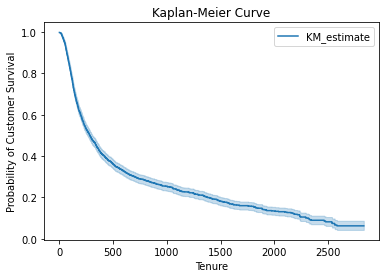

In [10]:
#Create a KaplanMeier object, imported from lifelines
kmf = KaplanMeierFitter()
#Calculate the K-M curve
kmf.fit(timevar,event_observed = eventvar)
#Plot the curve and assign labels
kmf.plot()
plt.ylabel('Probability of Customer Survival')
plt.xlabel('Tenure')
plt.title('Kaplan-Meier Curve');

In [11]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,0.998320
3.0,0.997900
4.0,0.997900
5.0,0.997900
6.0,0.997059
...,...
2729.0,0.062378
2734.0,0.062378
2770.0,0.062378


In [12]:
naf = NelsonAalenFitter(alpha=0.05, 
                        nelson_aalen_smoothing = False).fit(timevar, 
                                                            eventvar)
naf.cumulative_hazard_.head()

,NA_estimate
timeline,
0.0,0.001680
3.0,0.002101
4.0,0.002101
5.0,0.002101
6.0,0.002943


In [13]:
survivaldata = survivaldata.set_index(['Emp_ID'])

In [14]:
# removing multicolinearity from the data
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [15]:
calculate_vif_(survivaldata,5)

dropping 'Joining Designation' at index: 5
dropping 'avg_salary' at index: 1
dropping 'Salary_max' at index: 7
dropping 'avg_business_value' at index: 1
dropping 'Age' at index: 0
dropping 'avg_quartely_rating' at index: 0
dropping 'Designation' at index: 1
dropping 'total_reportings' at index: 5
dropping 'total_business_value' at index: 4
dropping 'Salary_min' at index: 2
Remaining variables:
Index(['number_employment_days', 'promotion', 'Increment',
       'business_value_index', 'target', 'Gender_Male', 'City_C10', 'City_C11',
       'City_C12', 'City_C13', 'City_C14', 'City_C15', 'City_C16', 'City_C17',
       'City_C18', 'City_C19', 'City_C2', 'City_C20', 'City_C21', 'City_C22',
       'City_C23', 'City_C24', 'City_C25', 'City_C26', 'City_C27', 'City_C28',
       'City_C29', 'City_C3', 'City_C4', 'City_C5', 'City_C6', 'City_C7',
       'City_C8', 'City_C9', 'Education_Level_College',
       'Education_Level_Master'],
      dtype='object')


,number_employment_days,promotion,Increment,business_value_index,target,Gender_Male,City_C10,City_C11,City_C12,City_C13,...,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9,Education_Level_College,Education_Level_Master
Emp_ID,,,,,,,,,,,,,,,,,,,,,
1,78,0,0,21994.62,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,56,0,0,0.00,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,141,0,0,2482.27,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5,58,0,0,2075.17,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
6,154,0,0,8214.29,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,1904,1,0,11422.70,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2785,61,0,0,0.00,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2786,419,0,0,6718.59,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
profile_report = ProfileReport(survivaldata, title="Pandas Profiling Report")
profile_report.to_widgets()

Summarize dataset:   0%|          | 0/60 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Observations from pandas profiling

1. Education_Level_College is highly correlated with Education_Level_Master
2. Increment is highly correlated with promotion

In [17]:
columns_selected = ['number_employment_days', 'promotion',
                    'business_value_index', 'target', 'Gender_Male', 
                    'City_C10', 'City_C11','City_C12', 'City_C13', 
                    'City_C14', 'City_C15', 'City_C16', 'City_C17',
                    'City_C18', 'City_C19', 'City_C2', 'City_C20', 
                    'City_C21', 'City_C22','City_C23', 'City_C24', 
                    'City_C25', 'City_C26', 'City_C27', 'City_C28',
                    'City_C29', 'City_C3', 'City_C4', 'City_C5', 
                    'City_C6', 'City_C7','City_C8', 'City_C9', 
                    'Education_Level_Master']

survivaldata = survivaldata[columns_selected]

In [18]:
# Initialize and fit the model
coxph = CoxPHFitter()
coxph.fit(survivaldata, 
          duration_col='number_employment_days', 
          event_col='target')
coxph.print_summary() 

<lifelines.CoxPHFitter: fitted with 2381 total observations, 773 right-censored observations>
             duration col = 'number_employment_days'
                event col = 'target'
      baseline estimation = breslow
   number of observations = 2381
number of events observed = 1608
   partial log-likelihood = -10471.17
         time fit was run = 2021-11-21 15:26:43 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
promotion               -1.09       0.34       0.06            -1.20            -0.97                 0.30                 0.38
business_value_index    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Gender_Male             -0.05       0.96       0.05            -0.15             0.06                 0.86                 1.06
City_C10                 0.01       1.01       0.19            -0.36             0.38                 0.70                 1.46
City_C11                 0.17       1.19       0.20            -0.22             0.57                 0.80                 1.77
City_C12                 0.21       1.23       0.19            -0.17             0.59                 0.84                 1.80
City_C13                 0.29       1.34       0.19            -0.08             0.66                 0.92                 1.94
City_C14                -0.08       0.93       0.19            -0.45             0.30                 0.64                 1.34
City_C15                 0.03       1.04       0.18            -0.32             0.39                 0.72                 1.48
City_C16                -0.06       0.94       0.20            -0.44             0.33                 0.64                 1.39
City_C17                 0.05       1.05       0.19            -0.32             0.43                 0.72                 1.54
City_C18                -0.04       0.96       0.20            -0.44             0.36                 0.65                 1.43
City_C19                 0.04       1.04       0.21            -0.36             0.45                 0.69                 1.56
City_C2                  0.20       1.22       0.19            -0.18             0.57                 0.84                 1.78
City_C20                 0.01       1.01       0.17            -0.32             0.34                 0.73                 1.40
City_C21                 0.00       1.00       0.20            -0.39             0.39                 0.68                 1.48
City_C22                -0.02       0.98       0.20            -0.40             0.37                 0.67                 1.45
City_C23                 0.24       1.27       0.19            -0.13             0.61                 0.88                 1.84
City_C24                 0.24       1.28       0.20            -0.14             0.63                 0.87                 1.87
City_C25                -0.18       0.83       0.19            -0.56             0.20                 0.57                 1.22
City_C26                -0.07       0.94       0.18            -0.43             0.30                 0.65                 1.34
City_C27                 0.29       1.33       0.19            -0.08             0.65                 0.92                 1.92
City_C28                 0.26       1.29       0.19            -0.11             0.63                 0.89                 1.88
City_C29                 0.09       1.10       0.20            -0.29             0.48                 0.75                 1.61
City_C3                  0.06       1.06       0.19            -0.32             0.44                 0.72                 1.55
City_C4                  0.05       1.05       0.19            -0.33             0.44                 0.72                 1.55
City_C5                  0.08      

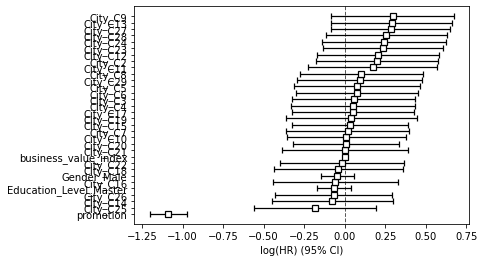

In [19]:
coxph.plot()

In [20]:
survivaldata = survivaldata.reset_index()

In [21]:
# loading test data provided
test_data = pd.read_csv('D:/History/AV/attrition_data_hackathon/data/test_hXY9mYw.csv')
test_data = survivaldata.merge(test_data, 
                               how = 'inner', 
                               on = 'Emp_ID')
emp_id = test_data[['Emp_ID']]

In [22]:
# Predictions for the test data
df_new = test_data[columns_selected]
df_new_obs = df_new['number_employment_days']# Predict survival probabilities 
pred = coxph.predict_survival_function(df_new,
                                       conditional_after=df_new_obs)

In [23]:
# filtering predictions for 2 quarters that is 183 days
pred = pred.reset_index()
pred = pred[pred['index']<183].drop('index', 
                                    axis = 1)

In [24]:
predictions = pd.DataFrame(pred.min()).reset_index()
emp_id = emp_id.reset_index()
final_predictions = pd.merge(predictions, 
                             emp_id, 
                             on = 'index')
final_predictions.drop('index', 
                       axis = 1, 
                       inplace = True)
final_predictions.columns = ["Probability", 
                             "Emp_ID"]
final_predictions["Target"] = np.where(final_predictions['Probability']<0.5, 1,0)
final_predictions["Target"].value_counts()
final_predictions.drop('Probability', 
                       axis = 1, 
                       inplace = True)
final_predictions.to_csv('D:/History/AV/attrition_data_hackathon/output/prediction_final.csv')